In [3]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import arch
from arch import arch_model

In [4]:
file_path = "COPY_Data_ESTAT_yields_daily_2024.06.20.xlsx"
df = pd.read_excel(file_path, sheet_name=2, header=[7])
df = df.drop(0)
df.head()

,TIME,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07,2000-01-10,2000-01-11,2000-01-12,2000-01-13,...,2024-06-06,2024-06-07,2024-06-10,2024-06-11,2024-06-12,2024-06-13,2024-06-14,2024-06-17,2024-06-18,2024-06-19
1,BE,5.68,5.73,5.72,5.77,5.73,5.65,5.73,5.80,5.80,...,3.08,3.11,3.25,3.28,3.21,3.15,3.08,3.08,3.1,3.08
2,DE,5.39,5.53,5.50,5.54,5.49,5.42,5.49,5.56,5.55,...,2.52,2.56,2.64,2.65,2.58,2.54,2.38,2.39,2.41,:
3,IE,5.73,5.73,5.73,5.78,5.72,5.65,5.79,5.81,5.77,...,2.94,3.01,3.09,3.05,2.96,2.96,2.87,2.89,:,:
4,ES,5.63,5.73,5.72,5.71,5.71,5.64,5.72,5.78,5.76,...,3.29,3.32,3.37,3.44,3.44,3.37,3.33,3.31,3.32,:
5,FR,5.6,5.60,5.62,5.67,5.60,5.52,5.64,5.65,5.64,...,3.04,3.12,3.24,3.24,3.16,3.18,:,:,:,:


In [5]:
# Set the first column as the index (Country codes)
df.set_index('TIME', inplace=True)

# Transpose the DataFrame to have dates as rows and countries as columns
df = df.transpose()

# Replace ':' with NaN
df.replace(':', np.nan, inplace=True)

# Drop columns beyond the 10th one
df = df.iloc[:, :10]

# Clean the index to ensure all values are valid dates
df.index = pd.to_datetime(df.index, errors='coerce')

# Drop rows with invalid dates
df = df.dropna(how='all', axis=0)
df

TIME,BE,DE,IE,ES,FR,IT,NL,AT,PT,FI
2000-01-03,5.68,5.39,5.73,5.63,5.60,5.64,5.61,5.55,5.61,5.62
2000-01-04,5.73,5.53,5.73,5.73,5.60,5.71,5.62,5.71,5.78,5.72
2000-01-05,5.72,5.50,5.73,5.72,5.62,5.69,5.62,5.71,5.79,5.69
2000-01-06,5.77,5.54,5.78,5.71,5.67,5.76,5.68,NaN,5.84,NaN
2000-01-07,5.73,5.49,5.72,5.71,5.60,5.67,5.60,5.71,5.74,5.69
...,...,...,...,...,...,...,...,...,...,...
2024-06-13,3.15,2.54,2.96,3.37,3.18,3.96,NaN,3.04,3.22,NaN
2024-06-14,3.08,2.38,2.87,3.33,NaN,3.93,NaN,2.97,3.16,NaN
2024-06-17,3.08,2.39,2.89,3.31,NaN,3.93,NaN,3.00,NaN,NaN
2024-06-18,3.10,2.41,NaN,3.32,NaN,3.90,NaN,2.97,NaN,NaN


In [6]:
# Initialize lists to store results
results_std = []
results_garch = []
results_ewma = []

# Function to calculate GARCH volatility
def garch_volatility(yields):
    if len(yields.dropna()) > 1:
        scaled_yields = yields.dropna() * 1000  # Rescaling yields
        model = arch_model(scaled_yields, vol='Garch', p=1, q=1, rescale=False)
        model_fitted = model.fit(disp='off')
        return model_fitted.conditional_volatility[-1] / 1000  # Rescaling back
    else:
        return None

# Define the lambda parameter for EWMA
lambda_ewma = 0.94

In [7]:


# Calculate mean and monthly volatility for each country
for country in df.columns:
    country_data = df[country].dropna().astype(float)
    
    # Calculate the mean yield
    avg_yield = country_data.mean()  # Mean yield, not in percentage terms
    
    # Calculate the monthly standard deviation of daily yields
    monthly_vol_std = country_data.resample('M').std()  # Monthly standard deviation
    
    # Calculate GARCH volatility
    garch_vol = country_data.resample('M').apply(garch_volatility)
    
    # Calculate EWMA volatility
    ewma_vol = country_data.ewm(span=30).std().resample('M').last()  # EWMA standard deviation
    
    # Append results for each date
    for date in monthly_vol_std.index:
        results_std.append([country, date, monthly_vol_std.loc[date]])
        results_garch.append([country, date, garch_vol.loc[date]])
        results_ewma.append([country, date, ewma_vol.loc[date]])



In [8]:
# Create DataFrames with the results
vol_df_std = pd.DataFrame(results_std, columns=['Country', 'Date', 'Standard_Deviation'])
vol_df_garch = pd.DataFrame(results_garch, columns=['Country', 'Date', 'GARCH'])
vol_df_ewma = pd.DataFrame(results_ewma, columns=['Country', 'Date', 'EWMA'])

# Merge the DataFrames on 'Country' and 'Date'
vol_df_combined = vol_df_std.merge(vol_df_garch, on=['Country', 'Date'], how='outer').merge(vol_df_ewma, on=['Country', 'Date'], how='outer')

# Pivot the combined DataFrame to get the desired format
vol_df_pivot = vol_df_combined.pivot_table(index='Date', columns='Country', values=['Standard_Deviation', 'GARCH', 'EWMA'])

# Flatten the MultiIndex columns
vol_df_pivot.columns = ['_'.join(col).strip() for col in vol_df_pivot.columns.values]

# Verify available columns
available_columns = vol_df_pivot.columns

# Reorder columns to group by country, only include columns that exist in the DataFrame
ordered_columns = []
for country in df.columns:
    for method in ['Standard_Deviation', 'GARCH', 'EWMA']:
        column_name = f'{method}_{country}'
        if column_name in available_columns:
            ordered_columns.append(column_name)
vol_df_pivot = vol_df_pivot[ordered_columns]

# Display the final DataFrame
print(vol_df_pivot.head())

            Standard_Deviation_BE  GARCH_BE   EWMA_BE  Standard_Deviation_DE  \
Date                                                                           
2000-01-31               0.069594  0.065160  0.065355               0.064767   
2000-02-29               0.057846  0.057369  0.060440               0.058420   
2000-03-31               0.093200  0.053768  0.112934               0.093587   
2000-04-30               0.063883  0.063032  0.092065               0.063173   
2000-05-31               0.071726  0.109926  0.092724               0.075947   

            GARCH_DE   EWMA_DE  Standard_Deviation_IE  GARCH_IE   EWMA_IE  \
Date                                                                        
2000-01-31  0.058307  0.059903               0.064209  0.062295  0.060162   
2000-02-29  0.058907  0.062816               0.057238  0.049233  0.063684   
2000-03-31  0.050130  0.114836               0.097980  0.058306  0.119380   
2000-04-30  0.087821  0.095141               0.054787 

In [9]:
vol_df_pivot.to_excel("new_volatilities.xlsx")

In [10]:
rg = pd.DataFrame(results_garch, columns=['Country', 'Time', 'Vol'])
rg_DE = rg[rg['Country'] == 'DE']
rg_DE

,Country,Time,Vol
294,DE,2000-01-31,0.058307
295,DE,2000-02-29,0.058907
296,DE,2000-03-31,0.050130
297,DE,2000-04-30,0.087821
298,DE,2000-05-31,0.195914
...,...,...,...
583,DE,2024-02-29,0.096466
584,DE,2024-03-31,0.044982
585,DE,2024-04-30,0.106667
586,DE,2024-05-31,0.143601


Text(0.5, 0, 'Date')

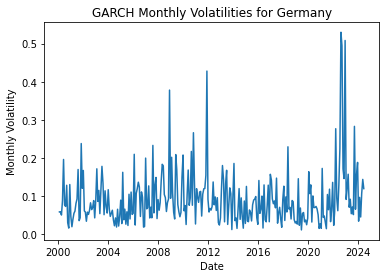

In [11]:
plt.plot(rg_DE['Time'], rg_DE['Vol'])
plt.title('GARCH Monthly Volatilities for Germany')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

In [12]:
rsd = pd.DataFrame(results_std, columns=['Country', 'Time', 'Vol'])
rsd_DE = rsd[rsd['Country'] == 'DE']
rsd_DE

,Country,Time,Vol
294,DE,2000-01-31,0.064767
295,DE,2000-02-29,0.058420
296,DE,2000-03-31,0.093587
297,DE,2000-04-30,0.063173
298,DE,2000-05-31,0.075947
...,...,...,...
583,DE,2024-02-29,0.098723
584,DE,2024-03-31,0.057718
585,DE,2024-04-30,0.076195
586,DE,2024-05-31,0.070944


Text(0.5, 0, 'Date')

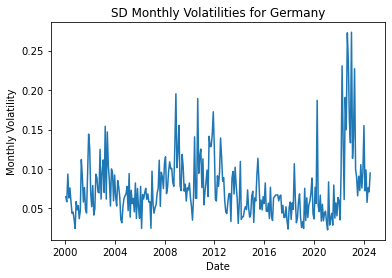

In [13]:
plt.plot(rsd_DE['Time'], rsd_DE['Vol'])
plt.title('SD Monthly Volatilities for Germany')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

In [14]:
rewma = pd.DataFrame(results_ewma, columns=['Country', 'Time', 'Vol'])
rewma_DE = rewma[rewma['Country'] == 'DE']
rewma_DE

,Country,Time,Vol
294,DE,2000-01-31,0.059903
295,DE,2000-02-29,0.062816
296,DE,2000-03-31,0.114836
297,DE,2000-04-30,0.095141
298,DE,2000-05-31,0.093876
...,...,...,...
583,DE,2024-02-29,0.130989
584,DE,2024-03-31,0.082869
585,DE,2024-04-30,0.095611
586,DE,2024-05-31,0.092970


Text(0.5, 0, 'Date')

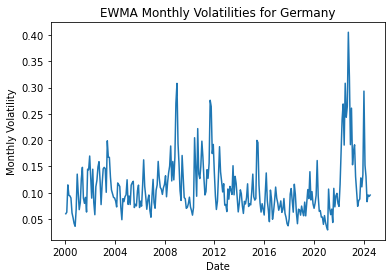

In [15]:
plt.plot(rewma_DE['Time'], rewma_DE['Vol'])
plt.title('EWMA Monthly Volatilities for Germany')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

# Avg of New Data (Temporary "EA"?)

In [16]:
EA_file_path = "ECB_10YR_combined_average_yield_per_day.xlsx"
EA_df = pd.read_excel(EA_file_path)
EA_df.set_index('Date', inplace=True)
# Clean the index to ensure all values are valid dates
EA_df.index = pd.to_datetime(EA_df.index)
EA_df.head()

,Average 10Y Bond Yield (10 EU Countries)
Date,
2000-01-03,5.6526
2000-01-04,5.6610
2000-01-05,5.6989
2000-01-06,5.7429
2000-01-07,5.6396


In [17]:
%store EA_df

Stored 'EA_df' (DataFrame)


In [18]:
ea10yr_daily_yeilds = EA_df['Average 10Y Bond Yield (10 EU Countries)'].to_numpy()
ea10yr_daily_yeilds

array([5.6526  , 5.661   , 5.6989  , ..., 3.075257, 3.132258, 3.197658])

In [19]:
EA_results_std = []
EA_results_garch = []
EA_results_ewma = []

EA_data = EA_df['Average 10Y Bond Yield (10 EU Countries)'].dropna().astype(float)/100

# Calculate the mean yield
EA_avg_yield = EA_data.mean()  # Mean yield, not in percentage terms

# Calculate the monthly standard deviation of daily yields
EA_monthly_vol_std = EA_data.resample('M').std()  # Monthly standard deviation

# Calculate GARCH volatility
EA_garch_vol = EA_data.resample('M').apply(garch_volatility)

EA_ewma_vol = EA_data.ewm(span=30).std().resample('M').last()  # EWMA standard deviation

# Append results for each date
for date in EA_monthly_vol_std.index:
    EA_results_std.append([date, EA_monthly_vol_std.loc[date]])

    # Append results for each date
for date in EA_garch_vol.index:
    EA_results_garch.append([date, EA_garch_vol.loc[date]])

for date in EA_ewma_vol.index:
    EA_results_ewma.append([date, EA_ewma_vol.loc[date]])

EA_vol_df_std = pd.DataFrame(EA_results_std, columns=['Date', 'Standard_Deviation'])
EA_vol_df_garch = pd.DataFrame(EA_results_garch, columns=['Date', 'GARCH Volatility'])
EA_vol_df_ewma = pd.DataFrame(EA_results_ewma, columns=['Date', 'EWMA Volatility'])
EA_vol_df_std

,Date,Standard_Deviation
0,2000-01-31,0.000641
1,2000-02-29,0.000603
2,2000-03-31,0.000984
3,2000-04-30,0.000575
4,2000-05-31,0.000749
...,...,...
289,2024-02-29,0.000529
290,2024-03-31,0.000551
291,2024-04-30,0.000701
292,2024-05-31,0.000620


In [20]:
%store EA_vol_df_garch
%store EA_vol_df_std
%store EA_vol_df_ewma
EA_vol_df_ewma


Stored 'EA_vol_df_garch' (DataFrame)
Stored 'EA_vol_df_std' (DataFrame)
Stored 'EA_vol_df_ewma' (DataFrame)


,Date,EWMA Volatility
0,2000-01-31,0.000598
1,2000-02-29,0.000636
2,2000-03-31,0.001181
3,2000-04-30,0.000857
4,2000-05-31,0.000888
...,...,...
289,2024-02-29,0.000952
290,2024-03-31,0.000680
291,2024-04-30,0.000856
292,2024-05-31,0.000762


Text(0.5, 0, 'Date')

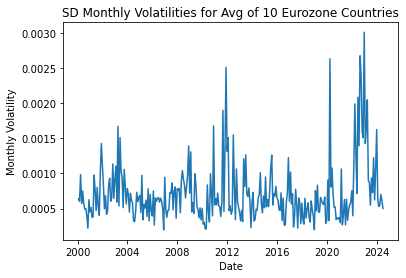

In [20]:
plt.plot(EA_vol_df_std['Date'], EA_vol_df_std['Standard_Deviation'])
plt.title('SD Monthly Volatilities for Avg of 10 Eurozone Countries')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

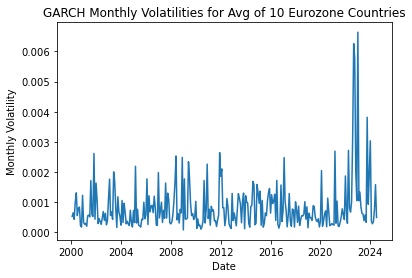

In [21]:
plt.plot(EA_vol_df_garch['Date'], EA_vol_df_garch['GARCH Volatility'])
plt.title('GARCH Monthly Volatilities for Avg of 10 Eurozone Countries')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

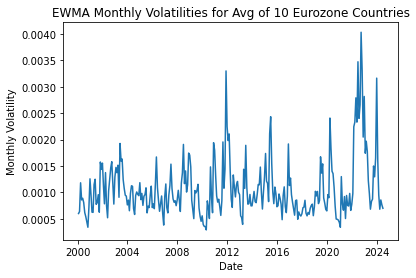

In [21]:
plt.plot(EA_vol_df_ewma['Date'], EA_vol_df_ewma['EWMA Volatility'])
plt.title('EWMA Monthly Volatilities for Avg of 10 Eurozone Countries')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')

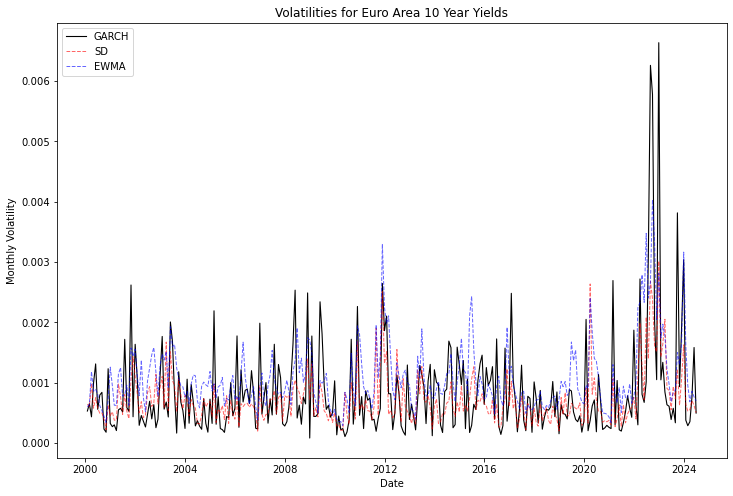

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(EA_vol_df_garch['Date'], EA_vol_df_garch['GARCH Volatility'], 'black', alpha = 1, lw=1.1, label='GARCH')
plt.plot(EA_vol_df_std['Date'], EA_vol_df_std['Standard_Deviation'], 'r--', alpha = .6, lw=1,  label='SD')
plt.plot(EA_vol_df_ewma['Date'], EA_vol_df_ewma['EWMA Volatility'], ls='--', color='b', alpha = .6, lw=1,  label='EWMA')
plt.title('Volatilities for Euro Area 10 Year Yields')
plt.ylabel('Monthly Volatility')
plt.xlabel('Date')
plt.legend()


In [75]:
np.mean(EA_vol_df_garch['GARCH Volatility']), np.mean(EA_vol_df_std['Standard_Deviation']), np.mean(EA_vol_df_ewma['EWMA Volatility'])

(0.0008332268149510687, 0.0007124930752842193, 0.0010704819915543936)

In [22]:
%store -r V_t_tau


(288,) (294,)


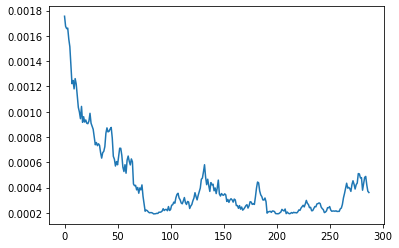

In [23]:
print(V_t_tau.shape, EA_vol_df_garch['GARCH Volatility'].shape)
plt.plot(V_t_tau)

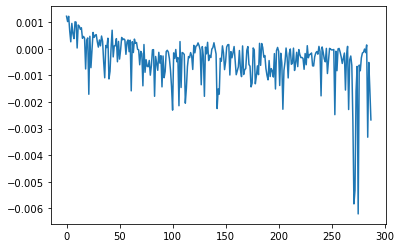

In [24]:
resid_eqn_9 = V_t_tau - EA_vol_df_garch['GARCH Volatility'][:-6]

plt.plot(resid_eqn_9)

In [25]:
import seaborn as sns
from scipy.stats import shapiro, kstest, norm, probplot

In [26]:
# shapiro_res = shapiro(resid_eqn_9)
shapiro_res = shapiro(EA_vol_df_garch['GARCH Volatility'])

Shapiro-Wilk test: ShapiroResult(statistic=0.6795462369918823, pvalue=3.02969950813618e-23)


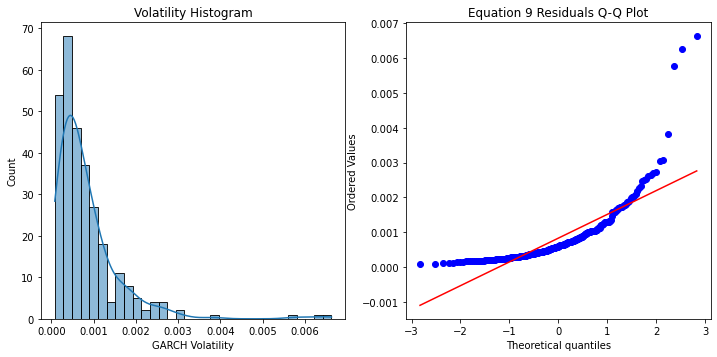

In [29]:
# Plotting
plt.figure(figsize=(12, 12))

# Histogram
plt.subplot(2, 2, 1)
sns.histplot(EA_vol_df_garch['GARCH Volatility'], kde=True)
plt.title(f'Volatility Histogram')

# Q-Q plot
plt.subplot(2, 2, 2)
probplot(EA_vol_df_garch['GARCH Volatility'], dist="norm", plot=plt)
plt.title(f'Equation 9 Residuals Q-Q Plot')

print(f"Shapiro-Wilk test: {shapiro_res}")